In [ ]:
#link google drive

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

#install any necessary packages to the colab env
!pip install wfdb
!pip install neurokit2
!pip install py-ecg-detectors
!pip install bigO

#from each package import relevant functions
import os
os.getcwd()
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/Orphanidou "
os.chdir(new_direct)
from orphanidou import assess_qual

path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/Automated_ecg_assessment_og'
os.chdir(path)
from toolbox.AlgorithmsV5_k_model import processing

import os
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/ECGAssess_og'
os.chdir(path)
from Code.AlgorithmsV5 import processing1

import os
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/framework_for_synthetic_biosignals"
os.chdir(new_direct)

import ecg_generator as eg
import noise_generator as ng
import beat_interval_generator as big
import tensorflow as tf

import sys
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project'
os.chdir(path)

from functions import plotting_df
from functions import first_below_05

#other tools to use
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from ecgdetectors import Detectors
import scipy.stats
import neurokit2 as nk
import time
import tensorflow as tf
import pandas as pd


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 797.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=d932c3a07eee4753d985ee02aa82d1b8c0f257dbd61d30b23a05cde134c29a33
  Stored in directory: /root/.cache/pip/wheels/13/39/c2/d113611d276bf55252ed5a640e98596d7dcc96535afbf254d5
Successfully built gatspy


In [ ]:
#Changing the WHITE NOISE:
#set the increment in white noise
increment = 10

# Create a dataframe with the following columns: noise type, signal, SQA1, SQA2, SQA3
df_HR = pd.DataFrame(columns=['Noise Type', 'SQA1', 'SQA2', 'SQA3', 'SQA4'])


# Generate ECG signals with increasing heart rates from a range of 5 to 1005 (cannot start at 0)
for i in range(0, 100):

    # Calculate heart rate for the current iteration
    hr = 5 + i * increment  # Incremental increase from 20 to 200 BPM
    print(hr)

    #create preset zero's array for efficiency
    SQA_O = np.zeros(100)
    SQA_Z = np.zeros(100)
    SQA_E = np.zeros(100)
    SQA_A = np.zeros(100)


    #add heart rate to the dataframe
    df_HR.at[i, 'Noise Type'] = str(hr)

    #create 100 variations with the same set variable
    for j in range(100):

      # Create ECG signal with the specified HR
      ecg = eg.ECGGenerator()
      ecg.number_of_beats = int(hr/4)
      ecg.beat_interval_generator.mu = 60/hr
      signal, peaks, labels, beats = ecg.generate()
      signal = signal[0:2000]

      #run the signal through Orphanidou SQI
      quality_o = assess_qual(signal, fs = 200, thresh = 0.66)

      #run the signal through the Zhao & Zhang SQI with a break, if code breaks due to not detecting HR then record as 'Unacceptable'
      try:
        quality_z = nk.ecg_quality(signal, sampling_rate=200, method="zhao2018")
      except Exception as e:
        print(f"An error occurred: {e}")
        quality_z = 'Unacceptable'

      #resample the signal (to 500Hz) and reshape into an array with the first row as the index (for final 2 SQI's)
      resampled_signal = nk.signal_resample(signal, sampling_rate=200, desired_sampling_rate=500, method="numpy")
      reshaped_array = np.vstack((np.arange(5000), resampled_signal))

      #run the processed signal through the ECGAssess (processsing1 func)
      quality_e = processing1(reshaped_array, total_leads=1, temp_freq=500)

      #run the prcoessed signal through the Elegendi SQI (processing func)
      qaulity_a = processing(reshaped_array, num_leads=1, temp_freq = 500, SNR_threshold = 0.5, signal_freq_band = [2, 40], window_length = 100, heart_rate_limits = [25, 300], max_loss_passband = 0.1,
               min_loss_stopband=20, sampling_frequency=500, path_model='/content/drive/MyDrive/Colab_Notebooks/CiC_work/Automated_ecg_assessment_og/cnn_lstm/', name_model = 'saved_model')

      #add the results of the orphanidou & Zhao Zhang SQI to the saved arrays
      SQA_O[j] = 0 if quality_o == 0 else 1
      SQA_Z[j] = 0 if quality_z == 'Unacceptable' else 1

      #for ECGAssess and Elgendi SQI's need to extract the final value in the SQI ('✖' = fail) and add to arrays
      ecg_result = 0 if quality_e[3][0] == '✖' else 1
      SQA_E[j] = 0 if ecg_result == 0 else 1

      auto_result = 0 if qaulity_a[4][0] == '✖' else 1
      SQA_A[j] = 0 if auto_result == 0 else 1


    #calculate the mean chance of pass value from each iteration of 100 signals and add to dataframe
    SQA_O_prob = np.mean(SQA_O)
    print(SQA_O_prob)
    df_HR.at[i, 'SQA1'] = SQA_O_prob

    SQA_Z_prob = np.mean(SQA_Z)
    print(SQA_Z_prob)
    df_HR.at[i, 'SQA2'] = SQA_Z_prob

    SQA_E_prob = np.mean(SQA_E)
    print(SQA_E_prob)
    df_HR.at[i, 'SQA3'] = SQA_E_prob

    SQA_A_prob = np.mean(SQA_A)
    print(SQA_A_prob)
    df_HR.at[i, 'SQA4'] = SQA_A_prob


path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)
df_HR.to_csv('HR_final')


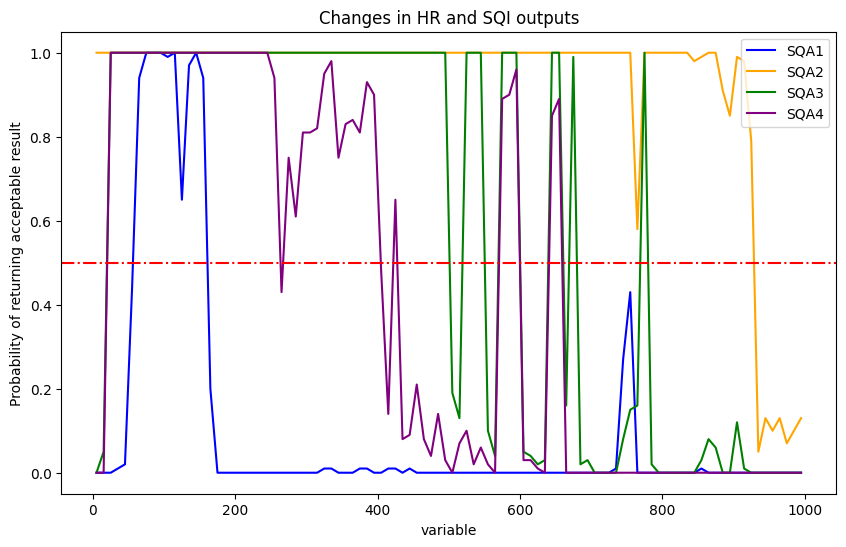

In [ ]:
#if cells above already run can then import the dataframe from saved_data file
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)

dfHR = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data/HR_final')

plotting_df(dfHR, 'Changes in HR and SQI outputs')

In [ ]:
dfHR[90:100]

,Unnamed: 0.1,Unnamed: 0,Noise Type,SQA1,SQA2,SQA3,SQA4
90,90,90,905,0.0,0.99,0.12,0.0
91,91,91,915,0.0,0.98,0.01,0.0
92,92,92,925,0.0,0.79,0.00,0.0
93,93,93,935,0.0,0.05,0.00,0.0
94,94,94,945,0.0,0.13,0.00,0.0
95,95,95,955,0.0,0.10,0.00,0.0
96,96,96,965,0.0,0.13,0.00,0.0
97,97,97,975,0.0,0.07,0.00,0.0
98,98,98,985,0.0,0.10,0.00,0.0
99,99,99,995,0.0,0.13,0.00,0.0


In [ ]:
#use the function first_below_05 to find the first value from each SQI that returned a value below 0.5
#to ignore low HR then the first 7 values in the dataframe are ignored
SQI1_hr = first_below_05(dfHR[7:100], 'SQA1')
print(SQI1_hr)
SQI2_hr = first_below_05(dfHR[7:100], 'SQA2')
print(SQI2_hr)
SQI3_hr = first_below_05(dfHR[7:100], 'SQA3')
print(SQI3_hr)
SQI4_hr = first_below_05(dfHR[7:100], 'SQA4')
print(SQI4_hr)

165
935
505
265


In [ ]:
#plot an ecg with the HR value immediately previous to where each SQI result turns to unacceptable (i.e. sub SQI3_hr for each of the SQI__hr)
increment = 10
heart_rate = SQI3_hr - increment
ecg = eg.ECGGenerator()
ecg.number_of_beats = int(heart_rate/4)
ecg.beat_interval_generator.mu = 60/heart_rate
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]
signal = signal[500:1000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 2.5)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 3, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

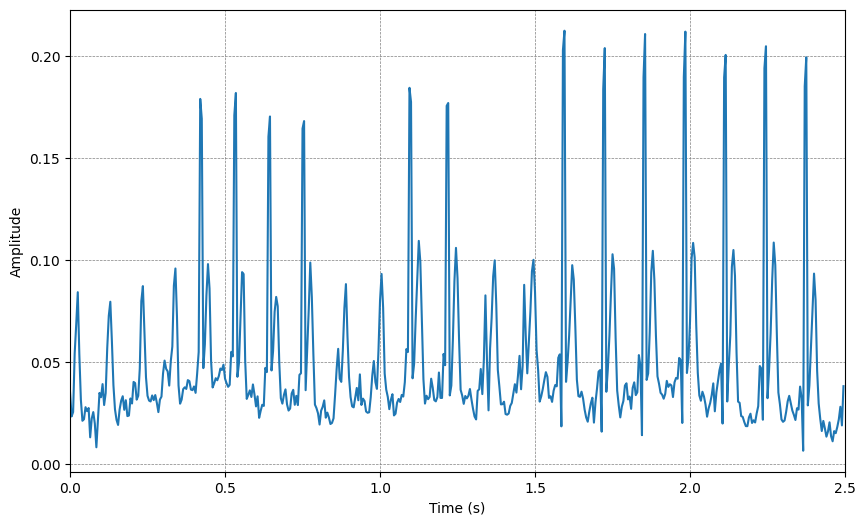

In [ ]:
#plot an ecg with the HR value immediately previous to where each SQI result turns to unacceptable (i.e. sub SQI3_hr for each of the SQI__hr) but with a zoomed in version of 2.5 seconds
increment = 10
heart_rate = SQI3_hr - increment
ecg = eg.ECGGenerator()
ecg.number_of_beats = int(heart_rate/4)
ecg.beat_interval_generator.mu = 60/heart_rate
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]
signal = signal[500:1000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 2.5)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 3, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [ ]:
ecg = eg.ECGGenerator()
ecg

ECGGenerator(noise_generator=NoiseGenerator(available_noise_types=['walking', 'hand_movement', 'muscle_artifact', 'baseline_wander'], fs=200, noise_list=[], amplitude_rng=[0.005, 0.25], noise_type=NoiseType(name='model', duration=30, amplitude=0.1, alpha=1.0, c=0.04, wn=0.01, point_bool=False, point_freq=0.5, point_value=1), alpha_rng=[0, 5], c_rng=[0.0, 4], wn_rng=[0.0, 3], point_prob=0.5, point_freq_rng=[0, 1], point_value_rng=[1, 10], artifact_bool=False, artifact_prob=0.5, artifact_amp=1, artifact_amp_rng=[0.1, 1], artifact_type='ma', artifact_start=0.5, artifact_start_rng=[0, 1], artifact_length=3, artifact_length_rng=[1, 10], artifact_idx=0.5, artifact_idx_rng=[0, 1]), beat_interval_generator=BeatIntervalGenerator(n=30, beat_intervals=None, mu=1.0, mu_rng=[0.4, 1.2], a=1.2, std=0.5, std_rng=[0.45, 0.55], b=0.075, bc=0.1, bf=0.2777777777777778, mu_new=0.75, mu_new_rng=[0.3, 2], step_i=0.5, step_i_rng=[0, 1], step_f=1, step_f_rng=[1, 10], step=False, step_prob=0.5, step_min=0.3, st